In [94]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

In [95]:
train_data = pd.read_csv('fashion-mnist_train.csv', dtype='float32')
train_data = np.array(train_data)
train_Y = train_data[:,[0]]
train_X = train_data[:,1:]

test_data = pd.read_csv('fashion-mnist_test.csv', dtype='float32')
test_data = np.array(train_data)
test_Y = test_data[:,[0]]
test_X = test_data[:,1:]

In [120]:
class BatchGenerator:
    where = 0
    def __init__(self, x, y, batch_size, one_hot = False, nb_classes = 0):
        self.nb_classes = nb_classes
        self.one_hot = one_hot
        self.x_ = x
        self.y_ = y
        self.batch_size = batch_size
        
        self.total_batch = int(len(x) / batch_size)
        self.x = self.x_[:batch_size,:]
        self.y = self.y_[:batch_size,:]
        self.where = batch_size
        
        if self.one_hot :
            self.set_one_hot()

    def next_batch(self):
        if self.where + self.batch_size > len(self.x_) :
            self.where = 0
            
        self.x = self.x_[self.where:self.where+self.batch_size,:]
        self.y = self.y_[self.where:self.where+self.batch_size,:]
        self.where += self.batch_size
        
        if self.one_hot:
            self.set_one_hot()
        
    def set_one_hot(self):
        self.y = np.int32(self.y)
        one_hot = np.array(self.y).reshape(-1).astype(np.int)
        self.y = np.eye(self.nb_classes)[one_hot]


class Layer:
    def __init__(self, name, mi, mo, f = tf.nn.leaky_relu):
        self.W = tf.get_variable('W%s' % name, shape=[mi,mo], initializer=tf.contrib.layers.xavier_initializer())
        self.b = tf.Variable(tf.random_normal([mo]))
        self.f = f
    
    def forward(self, X):
        out = tf.matmul(X, self.W) + self.b
        return self.f(out)
    

class Pre:
    def __init__(self, size, layers, nb_classes, learning_rate):
        self.X = tf.placeholder(tf.float32, shape=[None, size])
        self.Y = tf.placeholder(tf.float32, shape=[None, nb_classes])
        self.nb_classes = nb_classes
        layer = []
        mi = size
        count = 1
        for mo in layers:
            out = Layer(count, mi, mo)
            layer.append(out)
            mi = mo
            count += 1
        out = Layer(count, mi, nb_classes, f = lambda x:x)
        layer.append(out)
        
        X = self.X
        for i in layer:
            out = i.forward(X)
            X = out
        
        self.logits = X
        self.hypothesis = tf.nn.softmax(self.logits)
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2
                                  (logits=self.logits, labels=self.Y))
        correct_prediction = tf.equal(tf.argmax(self.hypothesis,1), tf.argmax(self.Y,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train(self, X, Y, batch_sz, steps):
        datas = BatchGenerator(X, Y, batch_size=batch_sz, one_hot=True, nb_classes=self.nb_classes)
        for step in range(steps):
            av_cost = 0
            for i in range(datas.total_batch):
                co_v, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {self.X:datas.x, self.Y:datas.y})
                av_cost += co_v / datas.total_batch
                datas.next_batch()
                
            print('step: {} cost: {:.8f}'.format(step+1, av_cost), end='\t')
            accuracy = self.sess.run(self.accuracy, feed_dict={self.X:datas.x, self.Y:datas.y})
            print('Accuracy: {:.5f}%'.format(accuracy * 100))
            
    def test(self, X, Y):
        test_set = BatchGenerator(X,Y,batch_size=len(X),one_hot=True, nb_classes=self.nb_classes)
        print('Accuracy: {:.2f}%'.format(self.accuracy.eval(session=self.sess, feed_dict={self.X:test_set.x, self.Y:test_set.y}) * 100))
        
        for i in range(9):
            r = random.randint(0, len(X))
            plt.subplot(3,3,i+1)
            plt.title('Label: {}, Pre: {}'.format(self.sess.run(
                tf.argmax(test_set.y[r:r+1], 1)), self.sess.run(tf.argmax(self.hypothesis,1),
                                                                feed_dict={self.X:test_set.x[r:r+1]})))
            plt.imshow(test_set.x[r:r+1].reshape(28, 28), cmap='Greys', interpolation='nearest')
            plt.tight_layout()

In [126]:
size = 784
layers = [256, 256, 256]
nb_classes = 10
batch_sz = 200
learning_rate = 0.001

step: 1 cost: 3.53577211	Accuracy: 79.00000%
step: 2 cost: 0.63617034	Accuracy: 81.50000%
step: 3 cost: 0.49556884	Accuracy: 83.00000%
step: 4 cost: 0.44594479	Accuracy: 84.00000%
step: 5 cost: 0.41079877	Accuracy: 84.50000%
step: 6 cost: 0.36476260	Accuracy: 86.50000%
step: 7 cost: 0.35351679	Accuracy: 87.00000%
step: 8 cost: 0.35010025	Accuracy: 86.00000%
step: 9 cost: 0.35284623	Accuracy: 89.00000%
step: 10 cost: 0.35534059	Accuracy: 89.00000%
step: 11 cost: 0.34460631	Accuracy: 85.50000%
step: 12 cost: 0.33681067	Accuracy: 87.50000%
step: 13 cost: 0.35602930	Accuracy: 88.50000%
step: 14 cost: 0.34139595	Accuracy: 85.00000%
step: 15 cost: 0.36111572	Accuracy: 84.50000%
step: 16 cost: 0.34641124	Accuracy: 86.00000%
step: 17 cost: 0.37018843	Accuracy: 85.50000%
step: 18 cost: 0.34517280	Accuracy: 83.00000%
step: 19 cost: 0.33194790	Accuracy: 88.00000%
step: 20 cost: 0.37179692	Accuracy: 88.00000%
step: 21 cost: 0.34169063	Accuracy: 89.50000%
step: 22 cost: 0.34502793	Accuracy: 90.0000

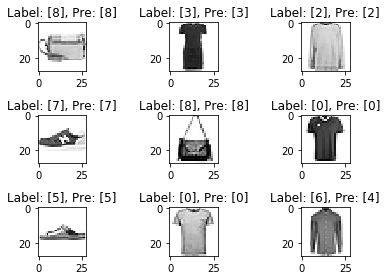

In [127]:
tf.reset_default_graph()
run = Pre(size, layers, nb_classes, learning_rate)
run.train(train_X, train_Y, batch_sz, 100)
run.test(test_X, test_Y)